# Assignment I Task-4

**Task-4** Anomaly Detection on two data sets (6 marks): 

Notes:

1). Predictive Maintenance Data: The data set tries to build an anomaly detection to predict and detect the machine failures. The dataset consists of 10000 data points stored as rows with 14 attributes in columns. You still need pre-processing and feature extraction for this data set. Particularly, the target is the attribute “Machine Failure” (0 for normal points and 1 for anomaly), and you could simple ignore the last five columns as they have been merged into the attribute “Machine Failure”. There are a several columns that might not be suitable to included. Note that the encoding of the target classes might affect the calculation of AUC scores.

2). Network Traffic Data: This is the data set used for a competition. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between “bad” connections, called intrusions or attacks, and “good” normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment. To facilitate your data analysis process, we have done sampling and data pre-processing for you. All the features are named as “Feature #”, and the last attribute is the label. The label just has two values (1 for normal data and -1 for anomalies).

3). You are required to perform anomaly detection on the two data sets with multiple methods. One-class SVM is optional while we encourage you to complete it by learning it from the sklearn online document.  


In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt

# Pre-processing
from sklearn import preprocessing

# Anomaly Detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
data1=pd.read_csv('data/predictive-maintenance/predictive-maintenance.csv')
print(data1.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


In [3]:
#Checking if any null values exist in the dataset
print(data1.isna().sum()/len(data1)*100)

#Removing veriables that do not contribute to our model
data1 = data1.drop(['TWF'], axis='columns')
data1 = data1.drop(['HDF'], axis='columns')
data1 = data1.drop(['PWF'], axis='columns')
data1 = data1.drop(['OSF'], axis='columns')
data1 = data1.drop(['RNF'], axis='columns')
data1 = data1.drop(['UDI'], axis='columns')
data1


UDI                        0.0
Product ID                 0.0
Type                       0.0
Air temperature [K]        0.0
Process temperature [K]    0.0
Rotational speed [rpm]     0.0
Torque [Nm]                0.0
Tool wear [min]            0.0
Machine failure            0.0
TWF                        0.0
HDF                        0.0
PWF                        0.0
OSF                        0.0
RNF                        0.0
dtype: float64


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M14860,M,298.1,308.6,1551,42.8,0,0
1,L47181,L,298.2,308.7,1408,46.3,3,0
2,L47182,L,298.1,308.5,1498,49.4,5,0
3,L47183,L,298.2,308.6,1433,39.5,7,0
4,L47184,L,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...,...
9995,M24855,M,298.8,308.4,1604,29.5,14,0
9996,H39410,H,298.9,308.4,1632,31.8,17,0
9997,M24857,M,299.0,308.6,1645,33.4,22,0
9998,H39412,H,299.0,308.7,1408,48.5,25,0


In [4]:
#checking format of our dataset as model takes numerical values
data1.dtypes

Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
dtype: object

In [5]:
#Converting 'Product ID' and 'Type' columns from type 'object' to 'category' so we can encode it.
data1["Type"] = data1["Type"].astype('category')
data1["Product ID"] = data1["Product ID"].astype('category')

#using pandas label encoding to encode Product ID and Type.
data1['Type'] = data1['Type'].cat.codes
data1['Product ID'] = data1['Product ID'].cat.codes

#storing feature values in X
X = data1.drop(['Machine failure'], axis='columns')

#Checking that targeted columns have been ecoded by printing the result of data manipulation on X.
print(X)

#normalizing the feature values stored in X.
scaler = preprocessing.MinMaxScaler()
X_data = X.values
X_scaled = scaler.fit_transform(X_data)
X = X_scaled

#storing label values in Y so that we can build our model in the next step.
y = data1['Machine failure'].values

#Let us calculate the anomaly rate that exist in this dateset.
print('\n Anomaly rate: %f \n' % (-1.0*(y-1).sum()/2.0/X.shape[0]))

      Product ID  Type  Air temperature [K]  Process temperature [K]  \
0           7003     2                298.1                    308.6   
1           1003     1                298.2                    308.7   
2           1004     1                298.1                    308.5   
3           1005     1                298.2                    308.6   
4           1006     1                298.2                    308.7   
...          ...   ...                  ...                      ...   
9995        9997     2                298.8                    308.4   
9996        1001     0                298.9                    308.4   
9997        9998     2                299.0                    308.6   
9998        1002     0                299.0                    308.7   
9999        9999     2                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  
0                       1551         42.8                0  
1            

In [6]:
# Let us create the LOF model.
detector_lof = LocalOutlierFactor(n_neighbors=10, novelty=True)

# training our model.
detector_lof.fit(X)

# Calculating anomaly score.
y_score = detector_lof.decision_function(X)
print(y_score)

[0.51294524 0.47309816 0.39191435 ... 0.47219449 0.47640622 0.41132922]


In [7]:
# Evaluating using Area Under Curve.
aucScore = roc_auc_score(y, y_score)
print('\n AUC score: %f\n' % aucScore)


 AUC score: 0.210709



In [8]:
# Predicting the Yes/No label.
y_pred = detector_lof.predict(X)
aucScore = roc_auc_score(y, y_pred)
print('\n AUC score: %f\n' % aucScore)


 AUC score: 0.472856



In [9]:
# Creating the iForest model.
detector_if = IsolationForest()

# Training our model model.
detector_if.fit(X)

# Calculating anomaly score.
y_score = detector_if.decision_function(X)
print(y_score)

[-0.00821731  0.00928343  0.0102187  ... -0.00155273 -0.02002052
  0.02216641]


In [10]:
# Evaluating using Area Under Curve.
aucScore = roc_auc_score(y, y_score)
print('\n AUC score: %f\n' % aucScore)


 AUC score: 0.255113



In [11]:
# Predict the Yes/No label.
y_pred = detector_if.predict(X)
print('\n AUC score: %f\n' % roc_auc_score(y, y_pred))


 AUC score: 0.344778



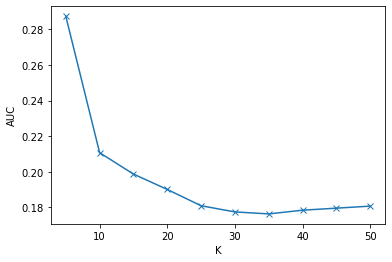

In [12]:
# Let us try different values of K to find an ideal candidate for our LOF model
auc_scores = []

for i in range(5, 51, 5): # K values from 5 to 51 with a step of 5
    
    detector_lof = LocalOutlierFactor(n_neighbors=i, novelty=True)
    detector_lof.fit(X) #Training model for each k value
    y_score = detector_lof.decision_function(X)
    auc = roc_auc_score(y, y_score) #calculating auc for each value of k
    auc_scores.append(auc) #storing the auc_score for each value of k in a list

#let us plot the relationship between auc and k
plt.plot(range(5, 51, 5), auc_scores, marker='x')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

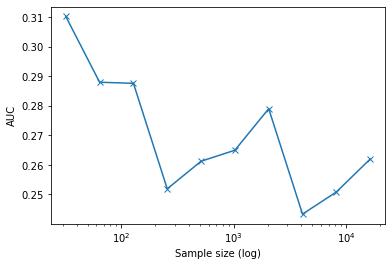


End of Task 4, Part 1


In [13]:
#Let us try different sample sizes for iforest to identify an ideal candidate.

auc_scores = []
sample_sizes = []
for i in range(5, 15):
    sample_sizes.append(2**i)
    detector_if = IsolationForest(max_samples=2**i)
    detector_if.fit(X)
    y_score = detector_if.decision_function(X)
    auc = roc_auc_score(y, y_score)
    auc_scores.append(auc)

#let us plot the relationship between auc and k
plt.plot(sample_sizes, auc_scores, marker='x')
plt.xscale('log')
plt.xlabel('Sample size (log)')
plt.ylabel('AUC')
plt.show()
print()
print("End of Task 4, Part 1")

In [14]:
#Task 4, Part 2 starts here

data2=pd.read_csv('data/network-traffic-analysis/kddcup99.csv')
#Let us check the data types present in our dataset
data2.dtypes

Feature 1     float64
Feature 2     float64
Feature 3     float64
Feature 4       int64
Feature 5     float64
Feature 6       int64
Feature 7     float64
Feature 8     float64
Feature 9       int64
Feature 10    float64
Feature 11      int64
Feature 12    float64
Feature 13    float64
Feature 14    float64
Feature 15    float64
Feature 16    float64
Feature 17      int64
Feature 18      int64
Feature 19      int64
Feature 20    float64
Feature 21    float64
Feature 22    float64
Feature 23    float64
Feature 24    float64
Feature 25    float64
Feature 26    float64
Feature 27    float64
Feature 28    float64
Feature 29    float64
Feature 30    float64
Feature 31    float64
Feature 32    float64
Feature 33    float64
Feature 34    float64
Feature 35    float64
Feature 36    float64
Feature 37    float64
Feature 38    float64
Label          object
dtype: object

In [15]:
df = pd.DataFrame(data2)
#Calculation of the anomaly rate initially resulted in an error "recieved str object, expected int". Going through
#the Label column showed that label value of row index 4022 was an alphabet 'f'. The assignment specification
#stated that preprocessing has already been done for this dataset and label values are 1 or -1. Hence, this single
#row was deemed as an error in the dataset and dropped. Once this single row was dropped, calculation of 
#performance metrics such as anomaly rate, auc score was successful. Furthermore, it was deemed that dropping this single
#row would not skew the performance of the final model at any significant rate. 
df.iloc[4022]
df = df.drop([4022]) 

#Converting Label column type from 'object' to 'integer'
df['Label'] = pd.to_numeric(df['Label'])
print(df.dtypes)

#Seperating dataset into X and y
X = df.drop(['Label'], axis='columns')
y = df['Label'].values

#Let us calculate the anomaly rate that exists in the dateset
print('\n Anomaly rate: %f \n' % (-1.0*(y-1).sum()/2.0/X.shape[0]))

Feature 1     float64
Feature 2     float64
Feature 3     float64
Feature 4       int64
Feature 5     float64
Feature 6       int64
Feature 7     float64
Feature 8     float64
Feature 9       int64
Feature 10    float64
Feature 11      int64
Feature 12    float64
Feature 13    float64
Feature 14    float64
Feature 15    float64
Feature 16    float64
Feature 17      int64
Feature 18      int64
Feature 19      int64
Feature 20    float64
Feature 21    float64
Feature 22    float64
Feature 23    float64
Feature 24    float64
Feature 25    float64
Feature 26    float64
Feature 27    float64
Feature 28    float64
Feature 29    float64
Feature 30    float64
Feature 31    float64
Feature 32    float64
Feature 33    float64
Feature 34    float64
Feature 35    float64
Feature 36    float64
Feature 37    float64
Feature 38    float64
Label           int64
dtype: object

 Anomaly rate: 0.035325 



In [16]:
# Let us create the LOF model.
detector_lof = LocalOutlierFactor(n_neighbors=10, novelty=True)

# Training the model
detector_lof.fit(X)

#Let us calculate the anomaly score
y_score = detector_lof.decision_function(X)
print(y_score)

[ 0.3588208  -1.44040281  0.53807342 ... -0.01533551  0.51375318
  0.48113802]


In [17]:
# Evaluating using Area Under Curve
aucScore = roc_auc_score(y, y_score)
print('\n AUC score: %f\n' % aucScore)


 AUC score: 0.634666



In [18]:
#Predicting the Yes/No label.
y_pred = detector_lof.predict(X)
aucScore = roc_auc_score(y, y_pred)
print('\n AUC score: %f\n' % aucScore)


 AUC score: 0.602527



In [19]:
# Let us create the iForest model.
detector_if = IsolationForest()

# Training the model
detector_if.fit(X)

#Let us calculate the anomaly score
y_score = detector_if.decision_function(X)
print(y_score)

[0.15426657 0.15520373 0.15292506 ... 0.14168734 0.14215301 0.12826713]


In [20]:
# Evaluating using Area Under Curve.
aucScore = roc_auc_score(y, y_score)
print('\n AUC score: %f\n' % aucScore)


 AUC score: 0.899743



In [21]:
# Predicting the Yes/No label. 
y_pred = detector_if.predict(X)
print('\n AUC score: %f\n' % roc_auc_score(y, y_pred))


 AUC score: 0.745782



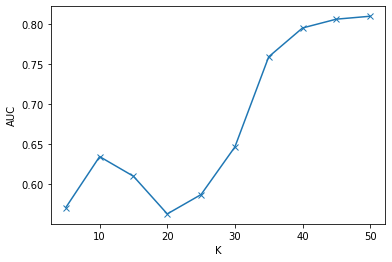

In [22]:
# Let us try different values of K to find an ideal candidate for our LOF model

auc_scores = []
for i in range(5, 51, 5): # K values from 5 to 51 with a step of 5
    detector_lof = LocalOutlierFactor(n_neighbors=i, novelty=True)
    detector_lof.fit(X) #training model for each k value
    y_score = detector_lof.decision_function(X)
    auc = roc_auc_score(y, y_score) #calculating auc score for each k
    auc_scores.append(auc) #storing auc score for each k in a list so that we can print a graph in the next step

# Let us plot the relationship between auc and k
plt.plot(range(5, 51, 5), auc_scores, marker='x')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

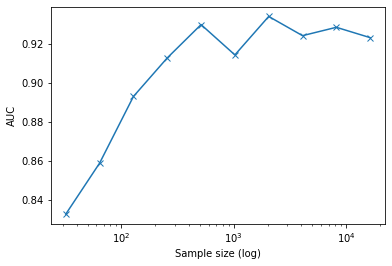

In [23]:
#Let us try different sample sizes for iforest to identify an ideal candidate.

auc_scores = []
sample_sizes = []
for i in range(5, 15):
    sample_sizes.append(2**i)
    detector_if = IsolationForest(max_samples=2**i)
    detector_if.fit(X)
    y_score = detector_if.decision_function(X)
    auc = roc_auc_score(y, y_score)
    auc_scores.append(auc)

#:Let us plot the relationship between auc and sample size.
plt.plot(sample_sizes, auc_scores, marker='x')
plt.xscale('log')
plt.xlabel('Sample size (log)')
plt.ylabel('AUC')
plt.show()